# Elo Customer Loyalty Prediction
# Scrap Work

This notebook contains my trial and error to improve the RMSE  of the customer loyalty score, through 
feature engieering, and model hyperparameter adjustments. 



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime

In [5]:
train =  pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
hist_trans = pd.read_csv('historical_transactions.csv')

In [7]:
new_merchants = pd.read_csv('new_merchant_transactions.csv')

In [8]:
from featexp import get_univariate_plots
import chartify

Loading BokehJS ...

In [ ]:
train.head()

In [ ]:
train.isnull().values.any() # Dataframe contains no null values, neat! 

In [ ]:
train.head()

In [ ]:
train.info() 

In [9]:
for df in [train, test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['year'] = df['first_active_month'].dt.year
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days

**Converting the first active month column into datetime format, and seperating the year and month into seperate columns so that we can inspect if theres any significance to month a user began**

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(train.target.values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.ylabel('Distrubution')
plt.show()

In [82]:
low_target = train.target < -30
low_target.value_counts()

False    199710
True       2207
Name: target, dtype: int64

**1% of the observations in the training set have an outlier targrt value of -33. Why is there a spike in target values at -33 and no where else. Perhaps there is a reason for this. But for model prediction these values maybe should be excluded**

In [ ]:
plt.figure(figsize=(12,8))
plt.plot_date(data=train, x='first_active_month', y='target', color= 'red')
plt.title('Scatterplot of Loyalty Score by First Active Month')
plt.xlabel('First Active Year')
plt.ylabel('Loyalty Score')
plt.show()

In [ ]:
cnt_srs = train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

<h1><center>The Distrubution Between the two sets appear similar</center></h1>

In [ ]:
hist_trans.head() #Contains information about the cusotmer transaction

In [ ]:
new_merchants.head() 
# contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) 
# over a period of two months.

**<center>Column Descriptions</center><br>**

card_id - Card identifier<br>

month_lag - month lag to reference date<br>

purchase_date - Purchase date<br>

authorized_flag - 'Y' if approved, 'N' if denied<br>

category_3 - anonymized category<br>

installments - number of installments of purchase<br>

category_1 - anonymized category<br>

merchant_category_id - Merchant category identifier (anonymized )<br>

subsector_id - Merchant category group identifier (anonymized )<br>

merchant_id - Merchant identifier (anonymized)<br>

purchase_amount - Normalized purchase amount<br>

city_id - City identifier (anonymized )<br>

state_id - State identifier (anonymized )<br>

category_2 - anonymized category<br>


In [ ]:
hist_trans.info()

In [ ]:
new_merchants.info()

In [10]:
hist_trans['authorized_flag'] = hist_trans['authorized_flag'].map({'Y':1, 'N':0})
hist_trans['category_1'] = hist_trans['category_1'].map({'Y':1, 'N':0})
hist_trans['category_3'] = hist_trans['category_3'].map({'A':1, 'B':2, 'C':3})
hist_trans = hist_trans.dropna()

In [11]:
new_merchants['authorized_flag'] = new_merchants['authorized_flag'].map({'Y':1, 'N':0})
new_merchants['category_1'] = new_merchants['category_1'].map({'Y':1, 'N':0})
new_merchants['category_3'] = new_merchants['category_3'].map({'A':1, 'B':2, 'C':3})
new_merchants = new_merchants.dropna()

In [12]:
hist_and_new = [hist_trans, new_merchants] 
Transactions = pd.concat(hist_and_new, keys=['Not_new', 'New_Merchant'])

In [13]:
def aggregate_historical_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max'],
        'category_1': ['sum', 'mean'],
        'category_2': ['sum', 'mean'],
        'category_3': ['sum', 'mean']

        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [14]:
grouped_trans = aggregate_historical_transactions(Transactions)

In [15]:
new_train = pd.merge(train, grouped_trans, on='card_id', how='left')
new_test = pd.merge(test, grouped_trans, on='card_id', how='left')

In [16]:
new_train = new_train.dropna()
new_test = new_test.dropna()

In [17]:
valid_mask = (new_train.elapsed_time < 100) | (new_train.elapsed_time > 800)

valid_mask.value_counts()

False    157778
True      39837
Name: elapsed_time, dtype: int64

In [18]:
valid = new_train[valid_mask]

valid.shape

(39837, 33)

In [19]:
train2_mask = (new_train.elapsed_time >= 100) & (new_train.elapsed_time <= 800)

train2 = new_train[train2_mask]

train2.shape

(157778, 33)

In [ ]:
train2.columns

In [ ]:
valid.columns

In [ ]:
new_train.columns

**Valid, will act as our validation set. We are going to test if many of the feature trends on the loyalty score remain constant between the training set, and the validation set, which is all the users that have been active for less than 100 days. Train2 does not contain the values in valid**

In [ ]:
new_train.head()

In [ ]:
new_train.columns

In [20]:
train3 = train2.drop('first_active_month', axis=1)
valid3 = valid.drop('first_active_month', axis=1)

card_id is categorical. Categorical features not supported yet.
                                         Plots for feature_1                                          
                                           Train data plots                                           


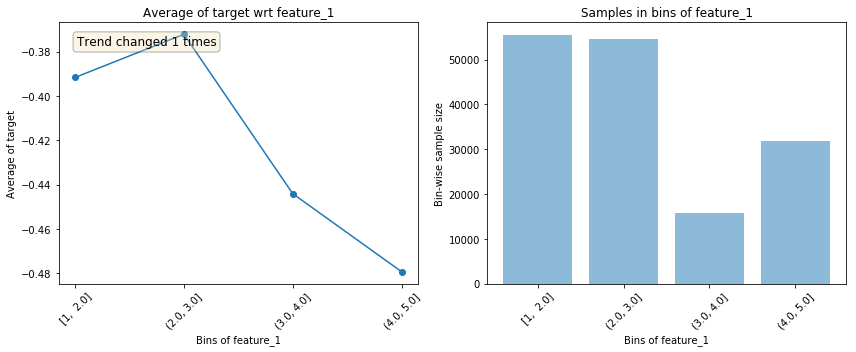

                                           Test data plots                                            


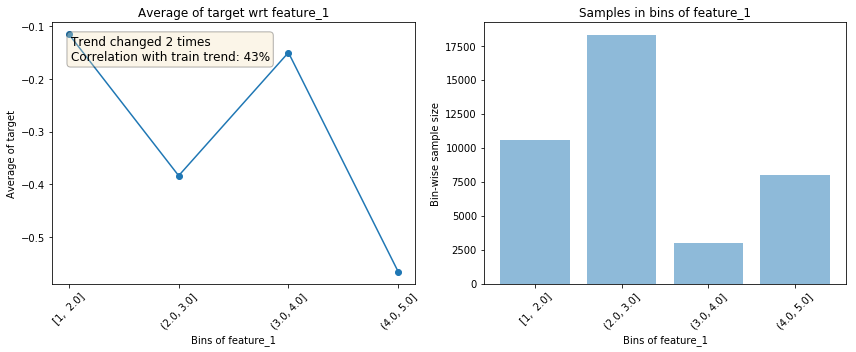

--------------------------------------------------------------------------------------------------------------


                                         Plots for feature_2                                          
                                           Train data plots                                           


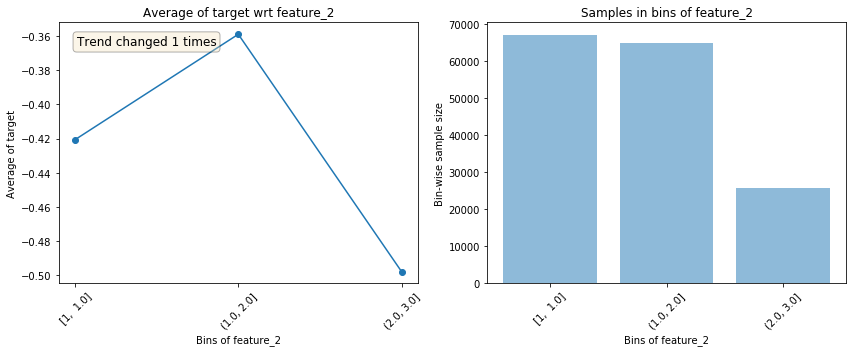

                                           Test data plots                                            


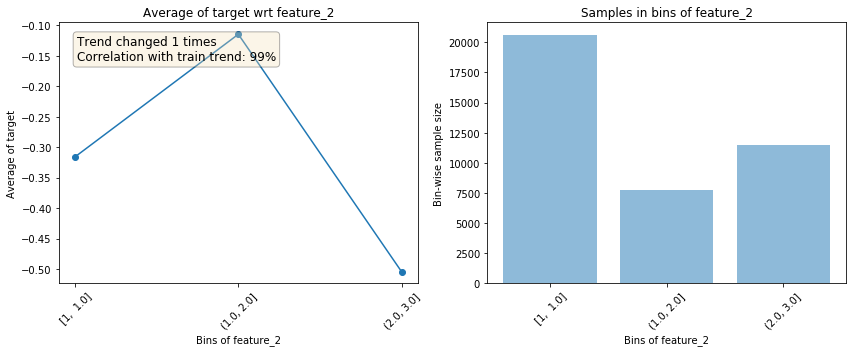

--------------------------------------------------------------------------------------------------------------


                                         Plots for feature_3                                          
                                           Train data plots                                           


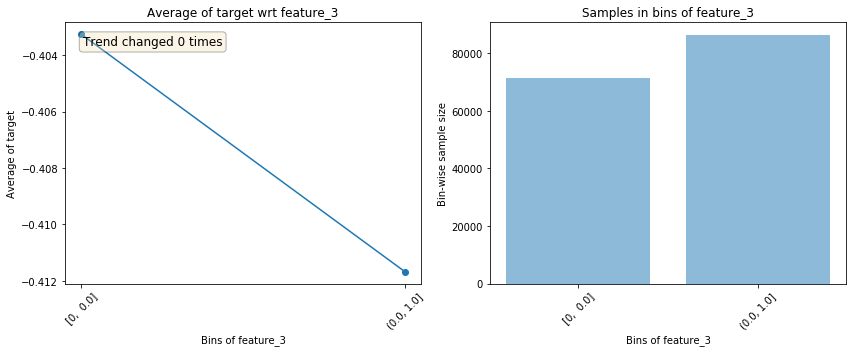

                                           Test data plots                                            


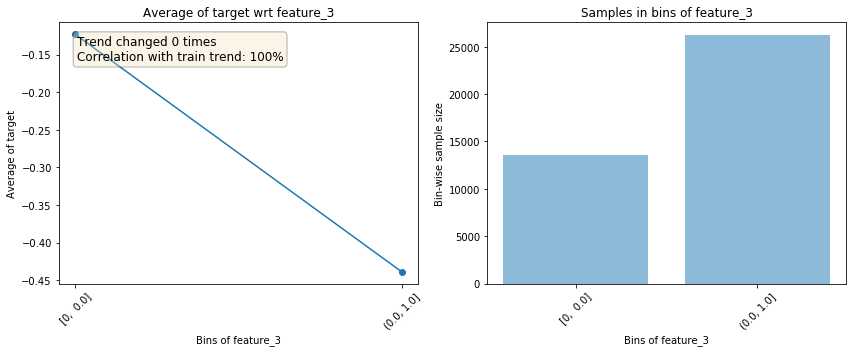

--------------------------------------------------------------------------------------------------------------


                                            Plots for year                                            
                                           Train data plots                                           


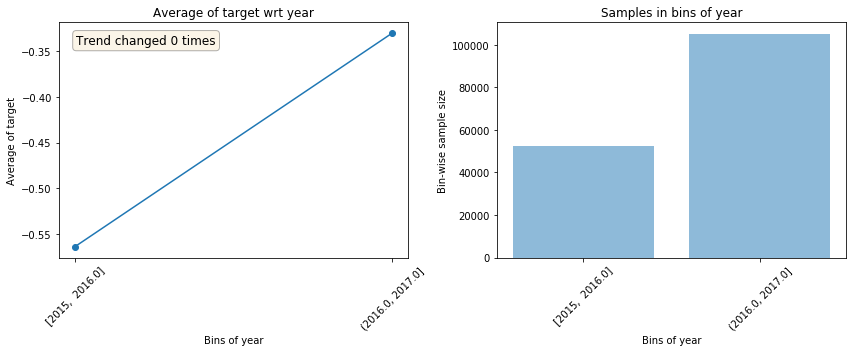

                                           Test data plots                                            


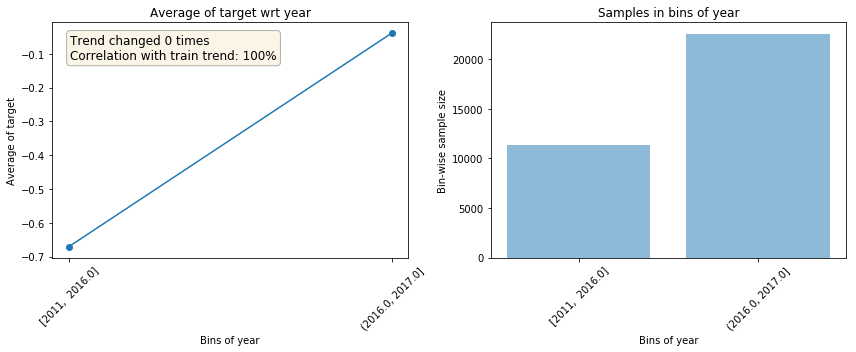

--------------------------------------------------------------------------------------------------------------


                                           Plots for month                                            
                                           Train data plots                                           


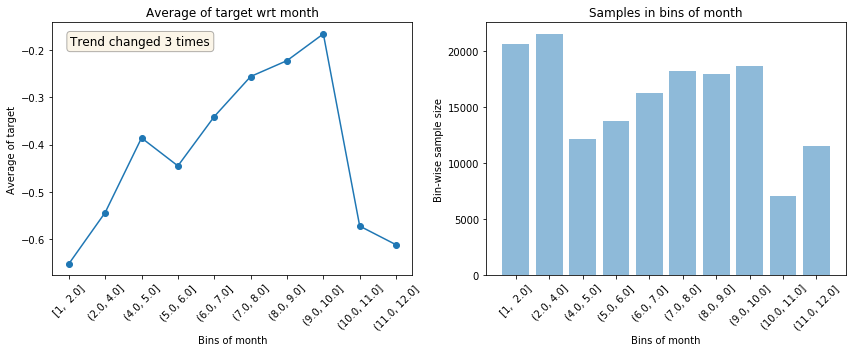

                                           Test data plots                                            


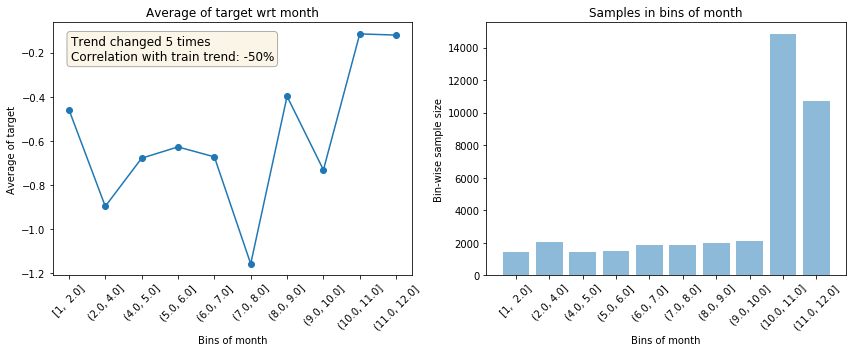

--------------------------------------------------------------------------------------------------------------


                                        Plots for elapsed_time                                        
Only one bin created for elapsed_time. Correlation can't be calculated
                                           Train data plots                                           


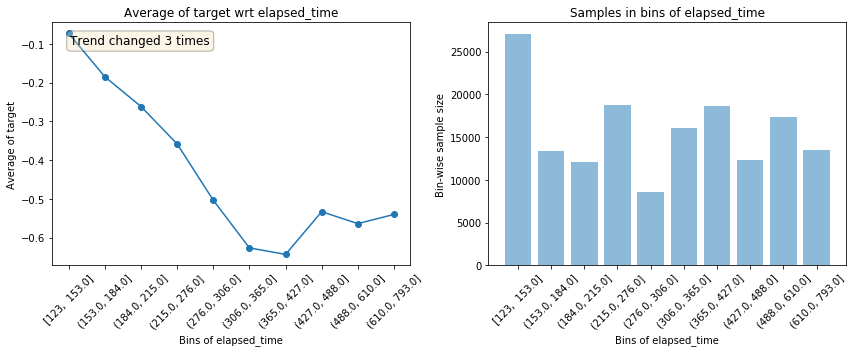

                                           Test data plots                                            


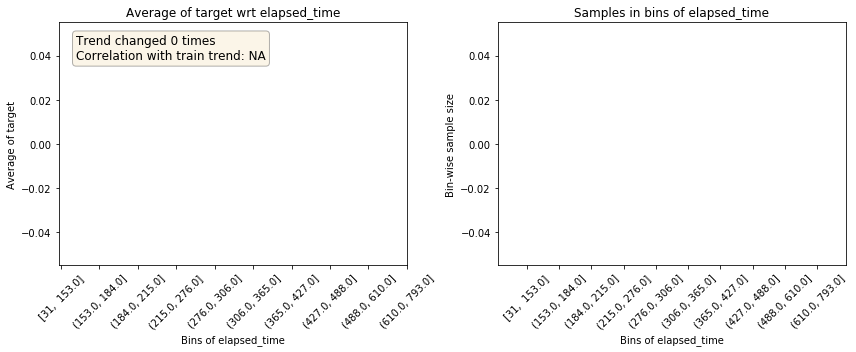

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_transactions_count                                   
                                           Train data plots                                           


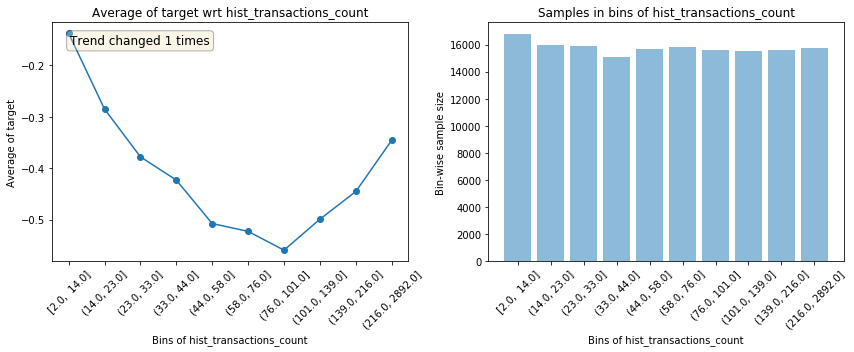

                                           Test data plots                                            


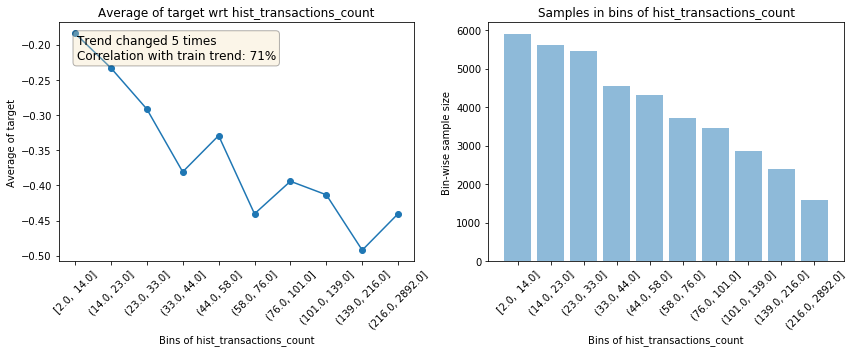

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_authorized_flag_sum                                  
                                           Train data plots                                           


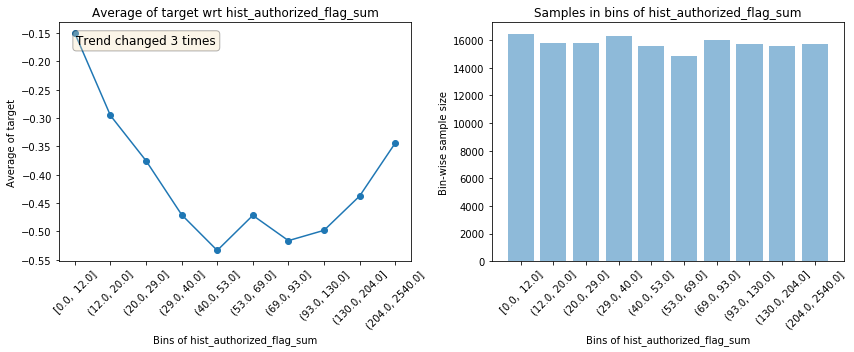

                                           Test data plots                                            


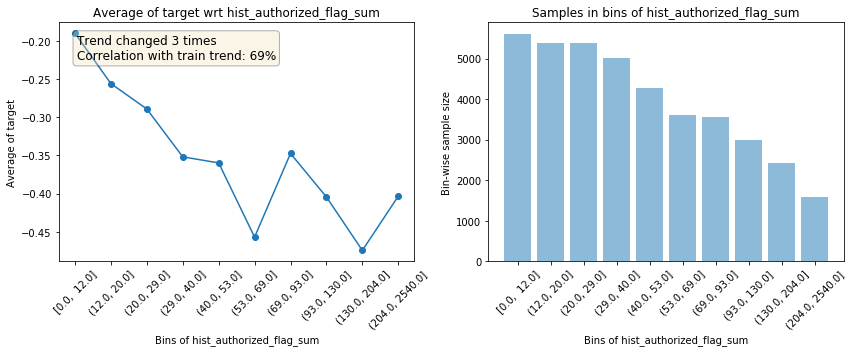

--------------------------------------------------------------------------------------------------------------


                                 Plots for hist_authorized_flag_mean                                  
                                           Train data plots                                           


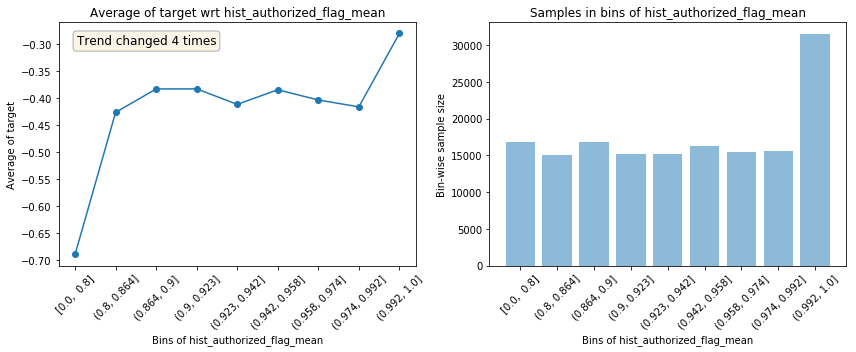

                                           Test data plots                                            


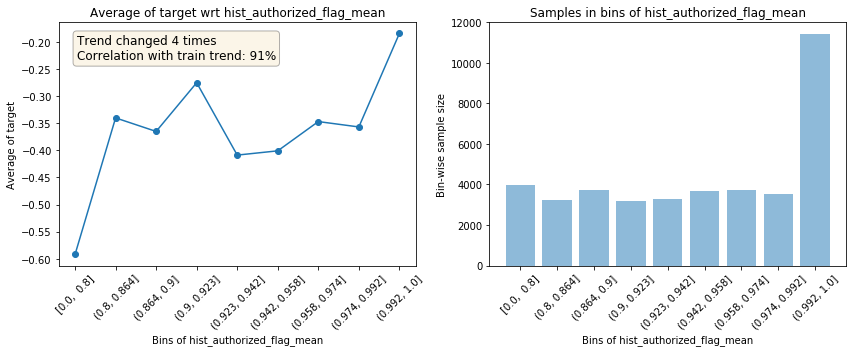

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_merchant_id_nunique                                  
                                           Train data plots                                           


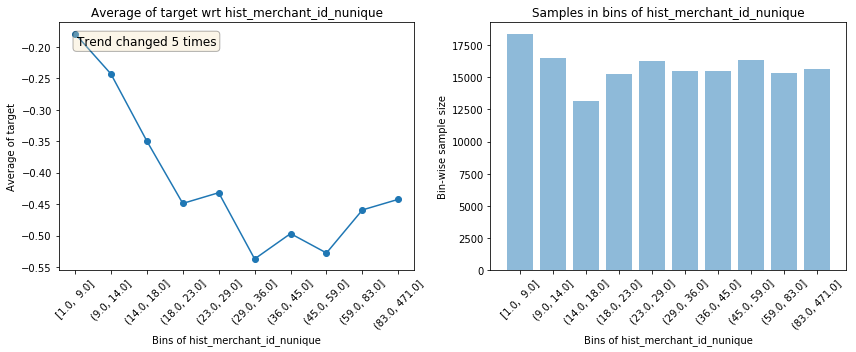

                                           Test data plots                                            


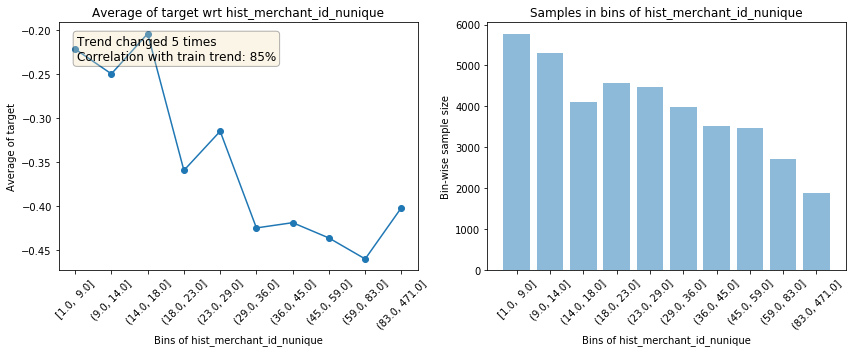

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_city_id_nunique                                    
                                           Train data plots                                           


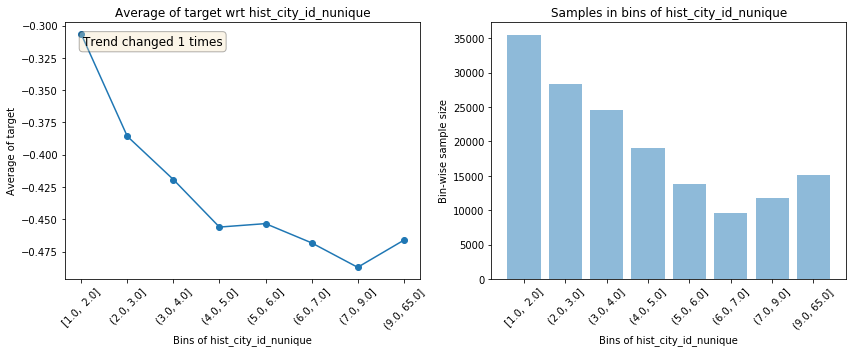

                                           Test data plots                                            


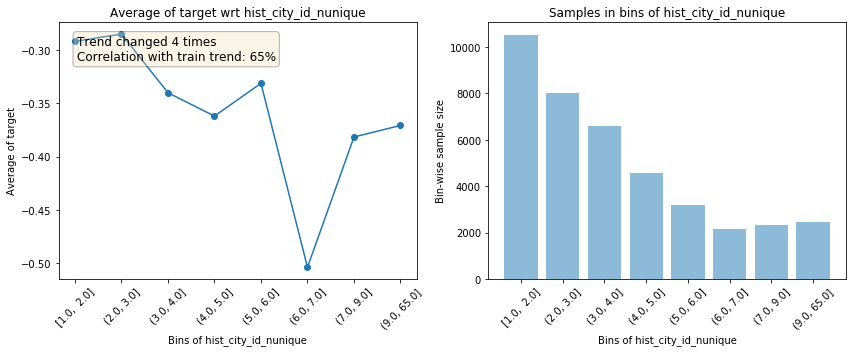

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_purchase_amount_sum                                  
                                           Train data plots                                           


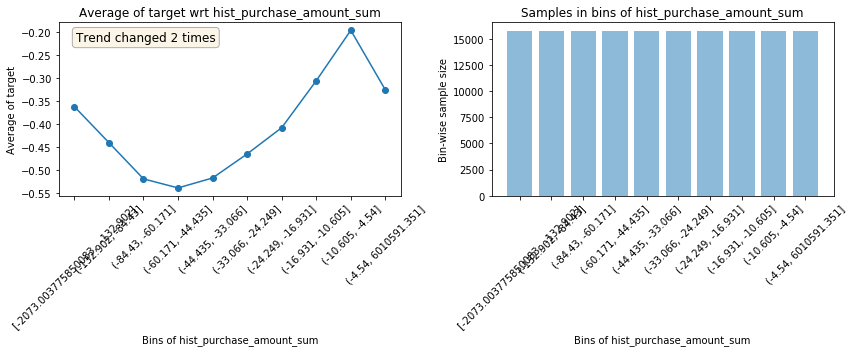

                                           Test data plots                                            


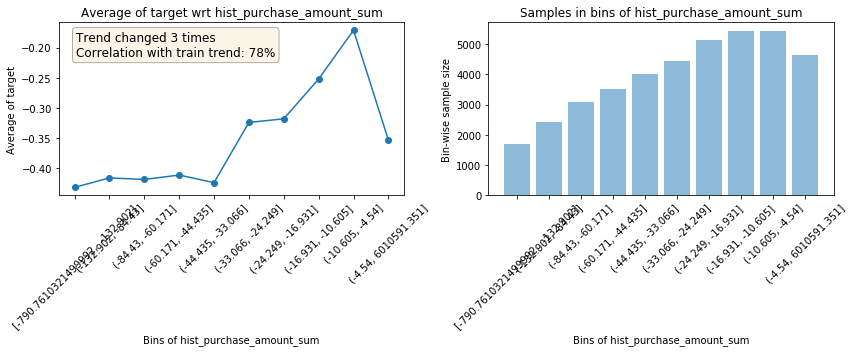

--------------------------------------------------------------------------------------------------------------


                                Plots for hist_purchase_amount_median                                 
                                           Train data plots                                           


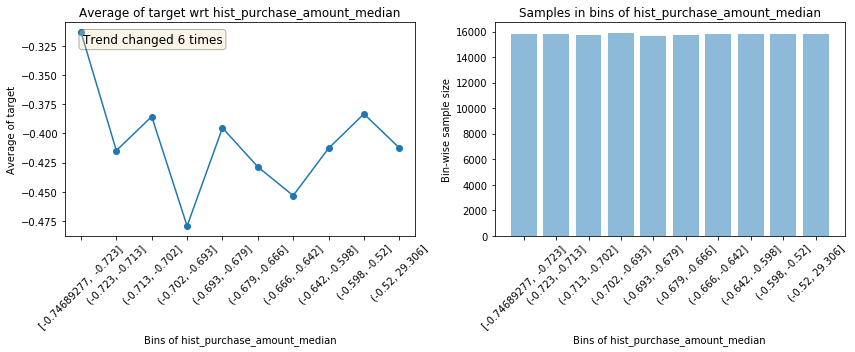

                                           Test data plots                                            


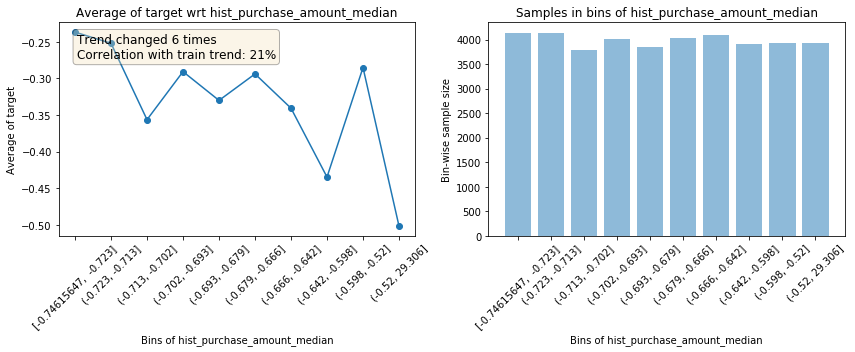

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_purchase_amount_max                                  
                                           Train data plots                                           


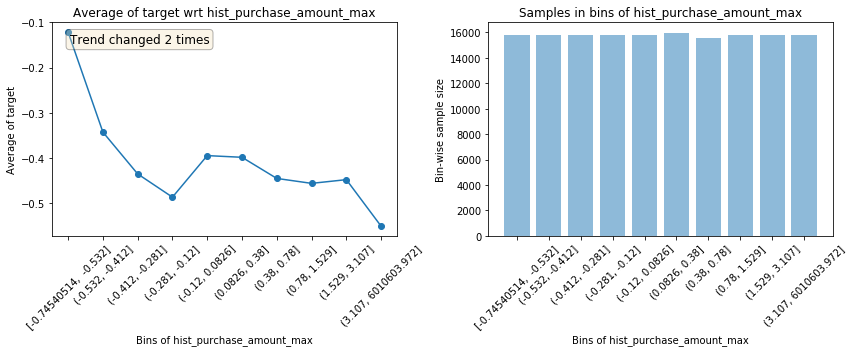

                                           Test data plots                                            


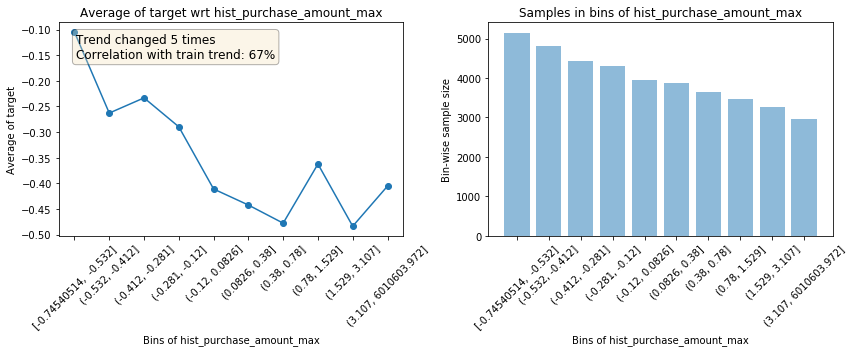

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_purchase_amount_min                                  
                                           Train data plots                                           


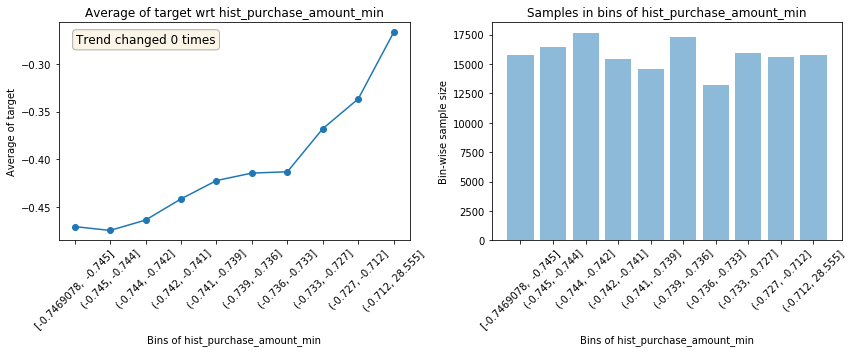

                                           Test data plots                                            


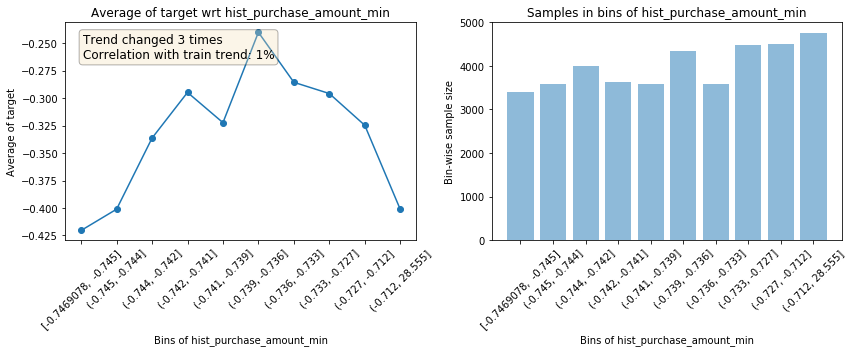

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_purchase_amount_std                                  
                                           Train data plots                                           


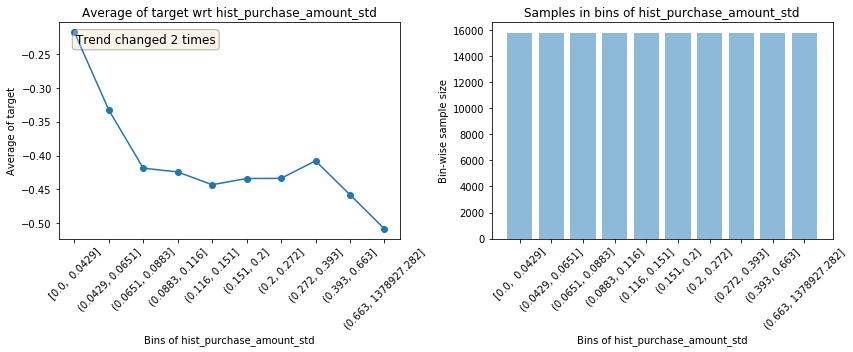

                                           Test data plots                                            


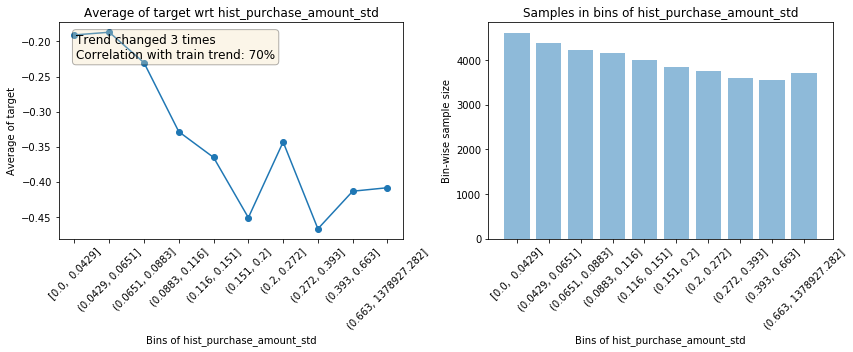

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_sum                                    
                                           Train data plots                                           


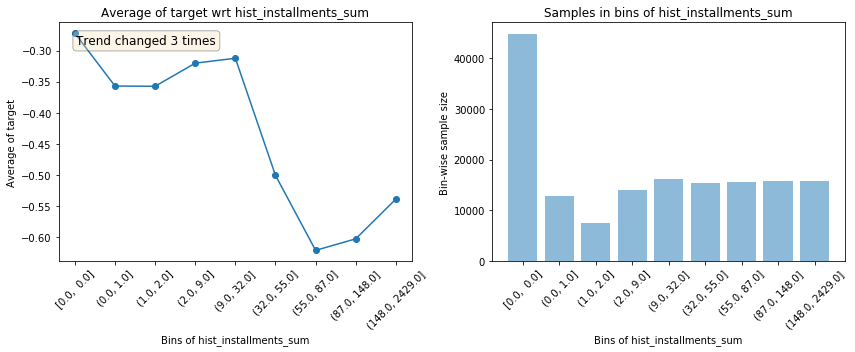

                                           Test data plots                                            


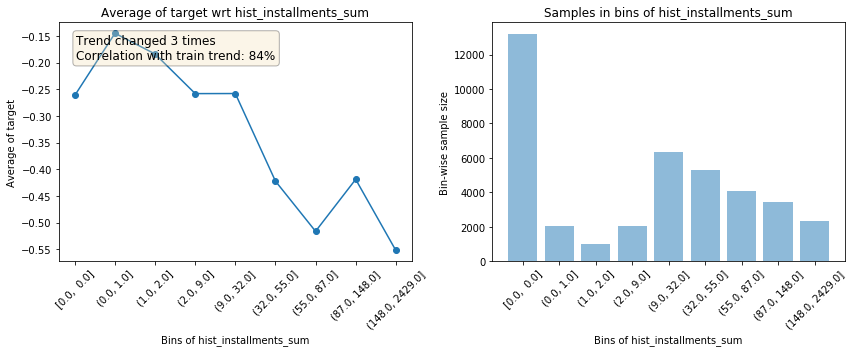

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_installments_median                                  
                                           Train data plots                                           


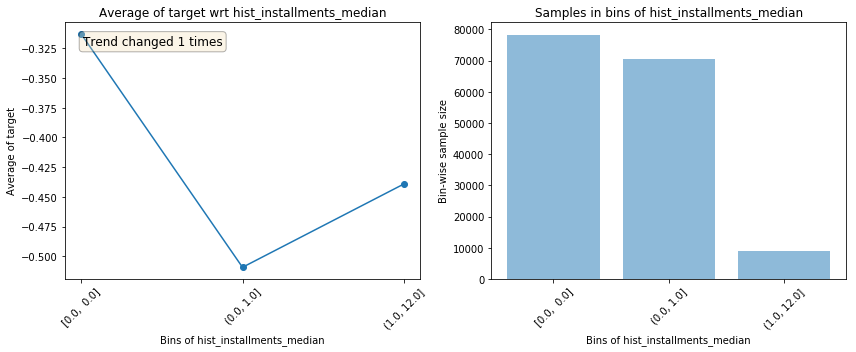

                                           Test data plots                                            


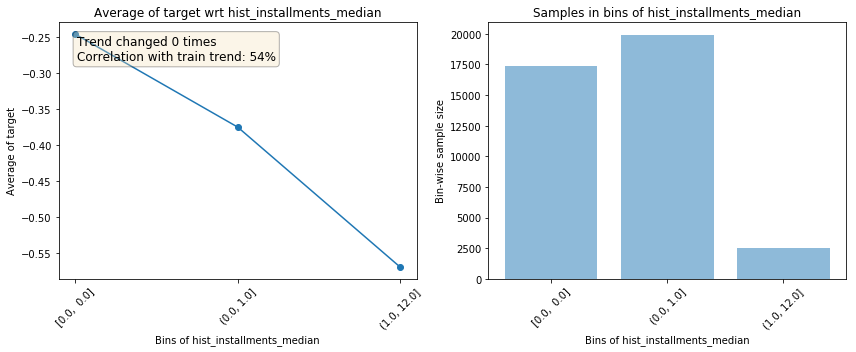

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_max                                    
                                           Train data plots                                           


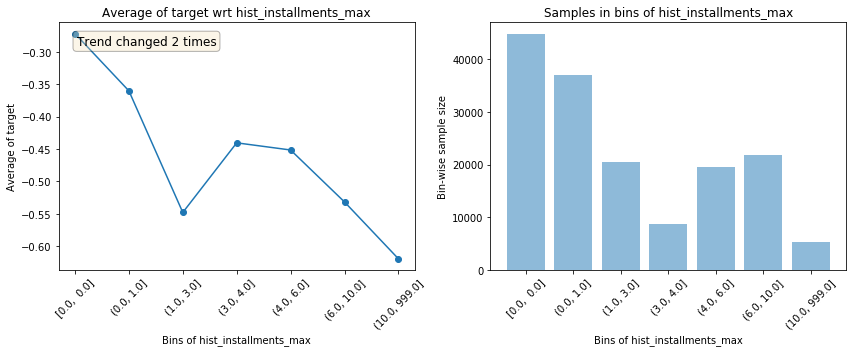

                                           Test data plots                                            


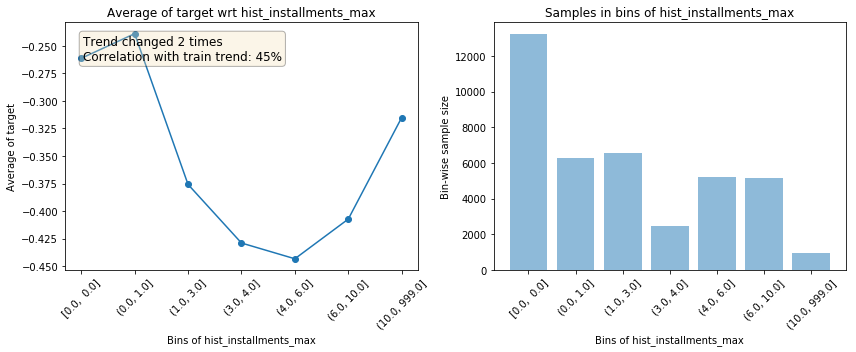

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_min                                    
                                           Train data plots                                           


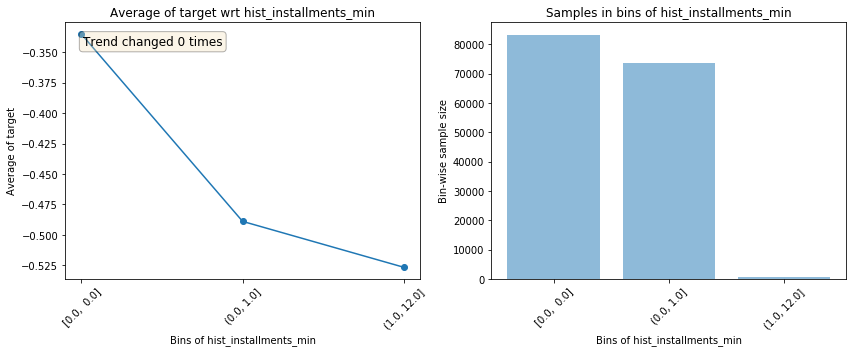

                                           Test data plots                                            


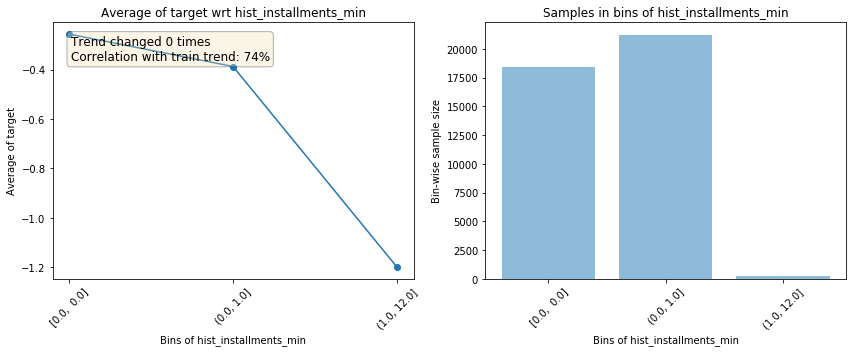

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_std                                    
                                           Train data plots                                           


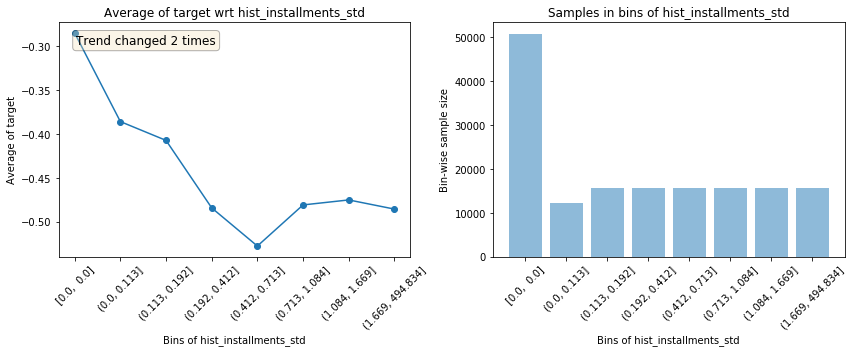

                                           Test data plots                                            


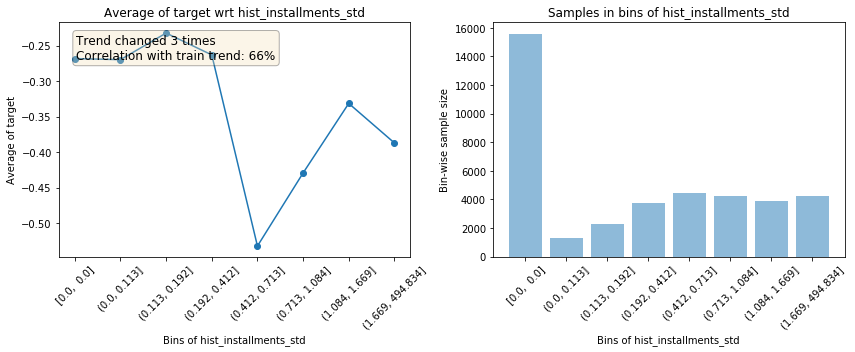

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_purchase_date_ptp                                   
                                           Train data plots                                           


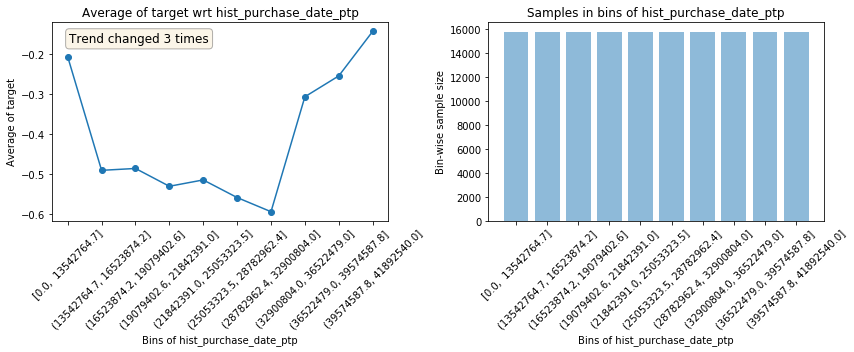

                                           Test data plots                                            


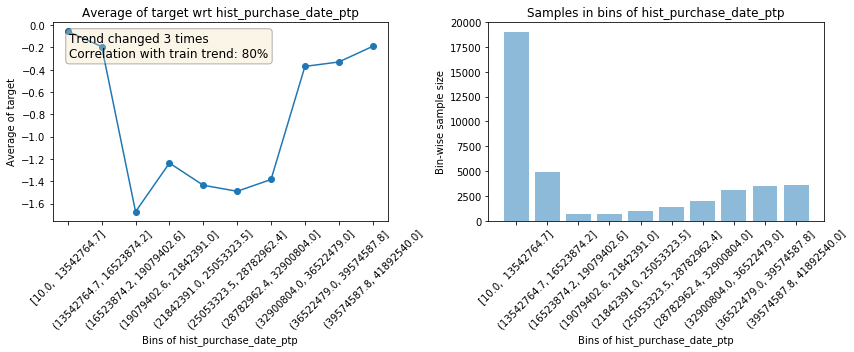

--------------------------------------------------------------------------------------------------------------


                                     Plots for hist_month_lag_min                                     
                                           Train data plots                                           


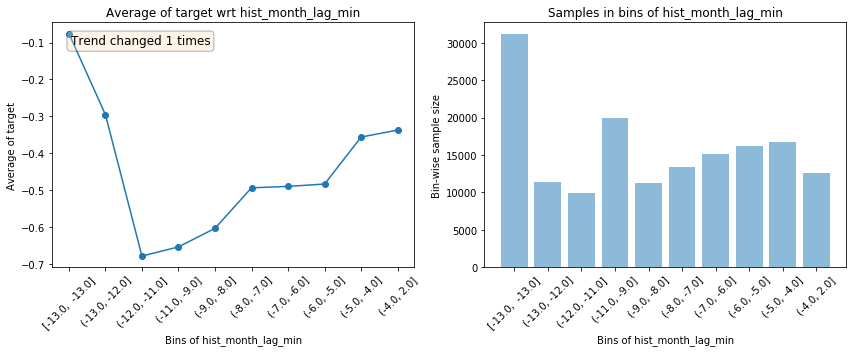

                                           Test data plots                                            


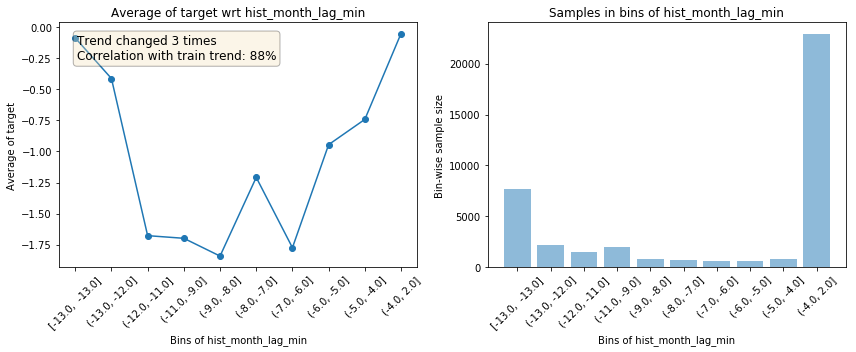

--------------------------------------------------------------------------------------------------------------


                                     Plots for hist_month_lag_max                                     
                                           Train data plots                                           


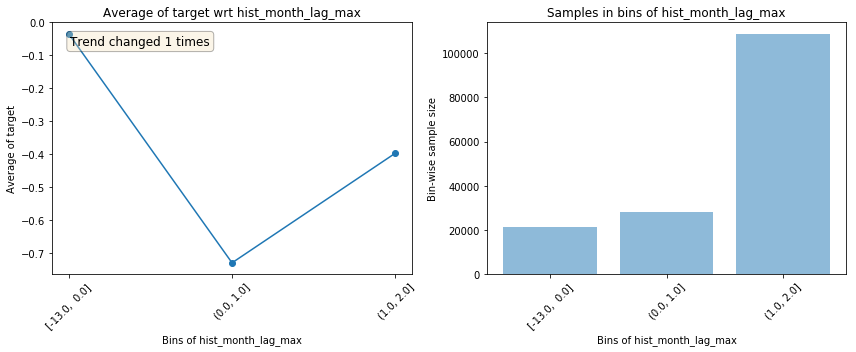

                                           Test data plots                                            


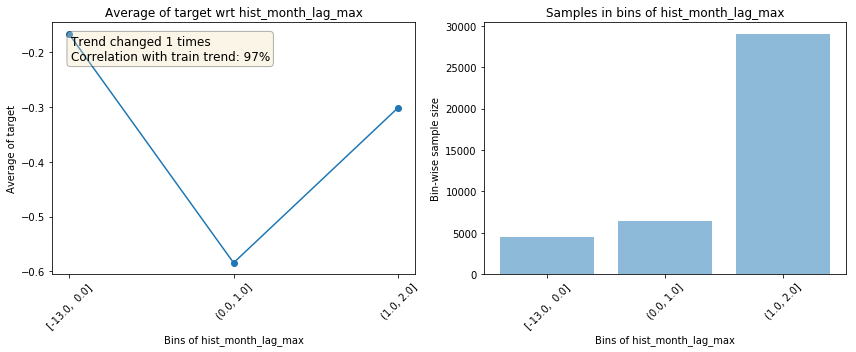

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_1_sum                                     
Only one bin created for hist_category_1_sum. Correlation can't be calculated
                                           Train data plots                                           


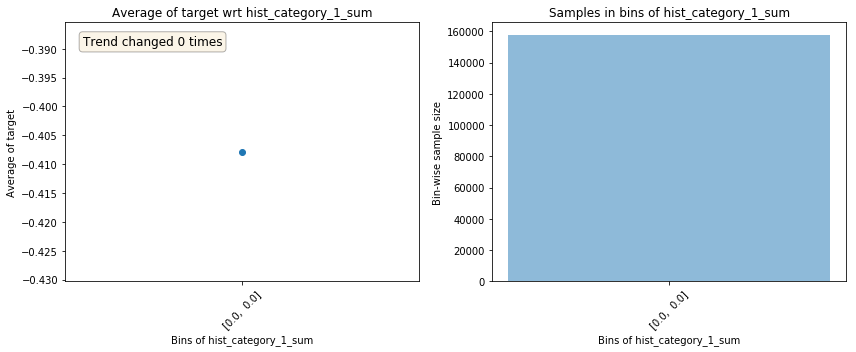

                                           Test data plots                                            


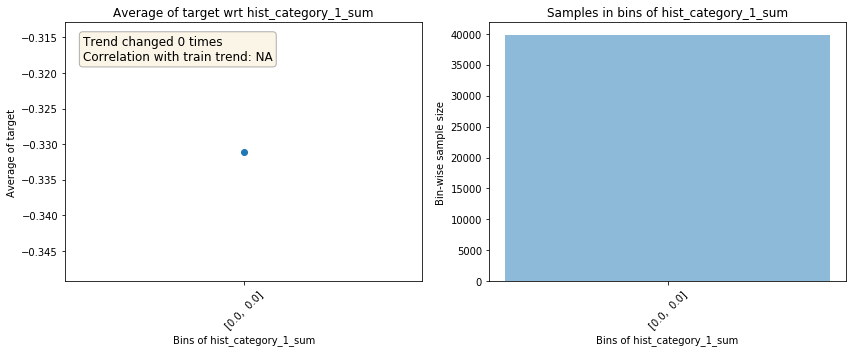

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_1_mean                                    
Only one bin created for hist_category_1_mean. Correlation can't be calculated
                                           Train data plots                                           


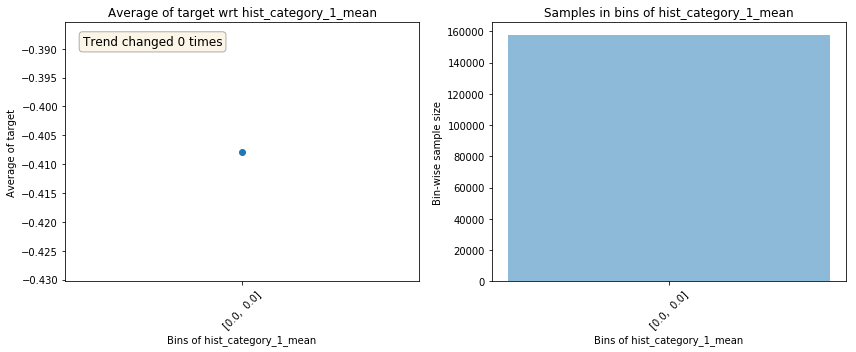

                                           Test data plots                                            


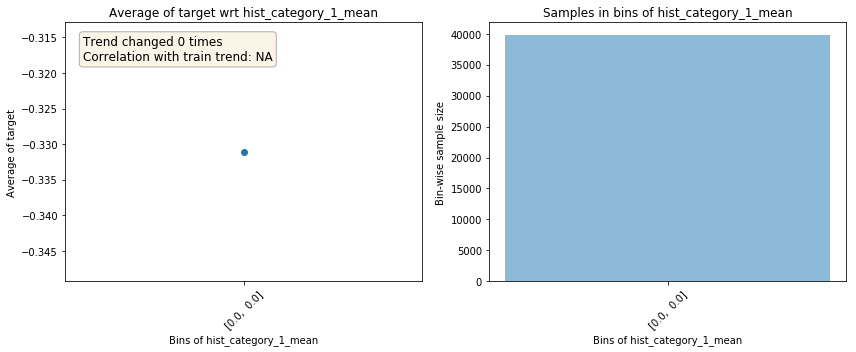

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_2_sum                                     
                                           Train data plots                                           


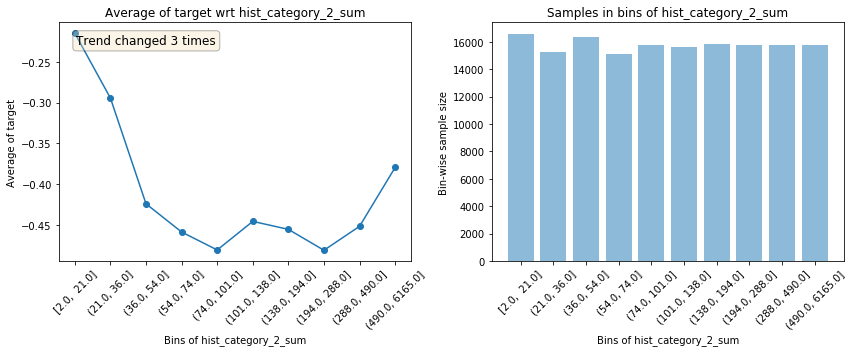

                                           Test data plots                                            


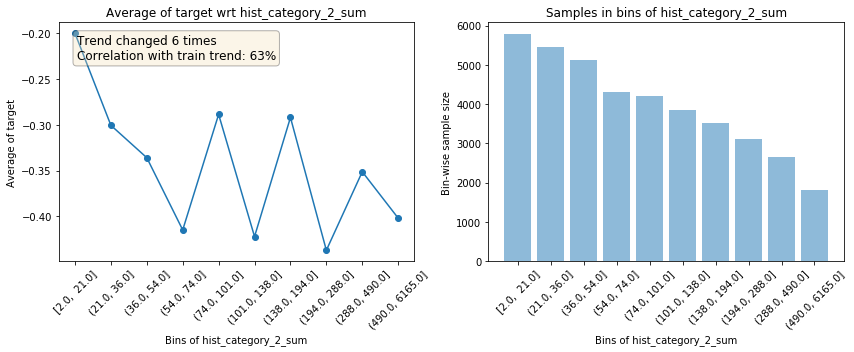

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_2_mean                                    
                                           Train data plots                                           


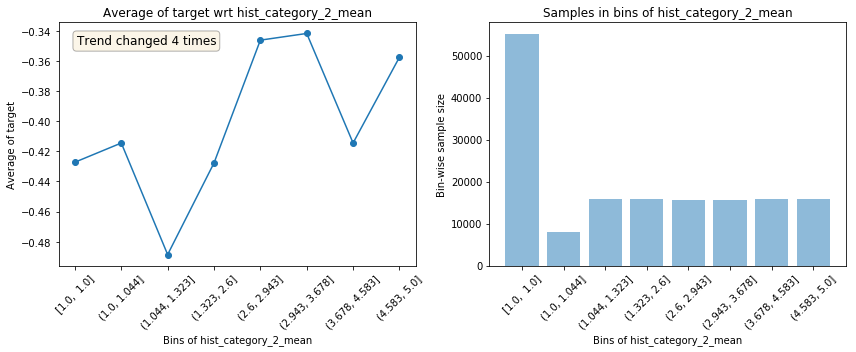

                                           Test data plots                                            


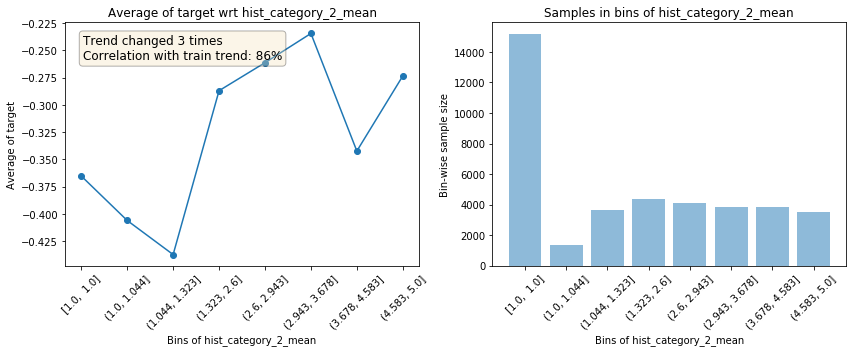

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_3_sum                                     
                                           Train data plots                                           


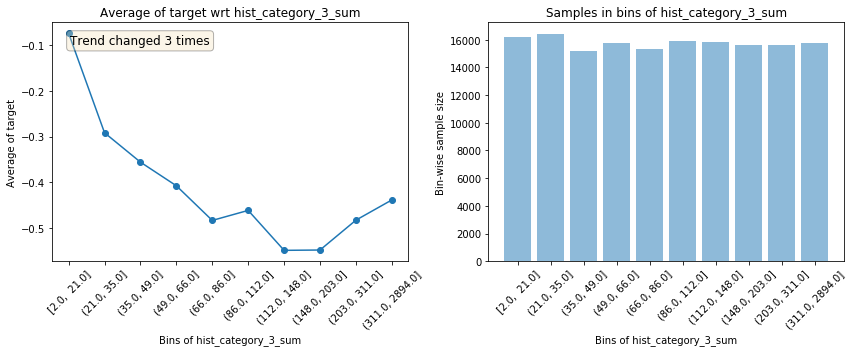

                                           Test data plots                                            


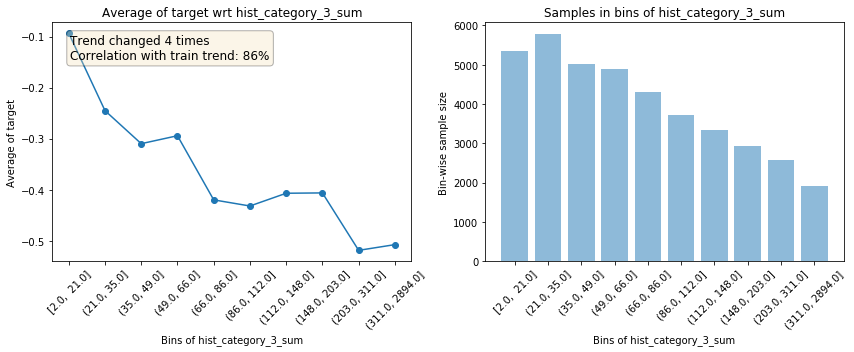

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_3_mean                                    
                                           Train data plots                                           


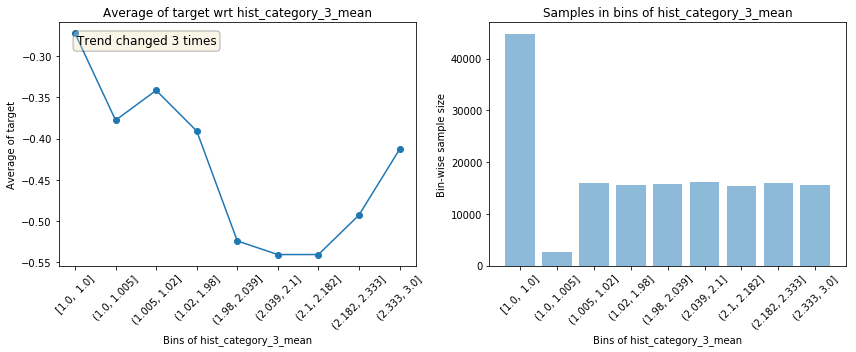

                                           Test data plots                                            


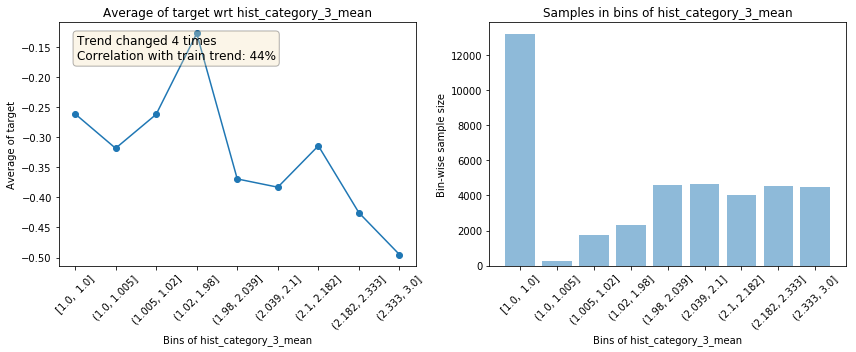

--------------------------------------------------------------------------------------------------------------




In [69]:
get_univariate_plots(data=train2, target_col='target', data_test=valid, features_list=[
                         
       'card_id', 'feature_1', 'feature_2', 'feature_3',
       'year', 'month', 'elapsed_time', 'hist_transactions_count',
       'hist_authorized_flag_sum', 'hist_authorized_flag_mean',
       'hist_merchant_id_nunique', 'hist_city_id_nunique',
       'hist_purchase_amount_sum', 'hist_purchase_amount_median',
       'hist_purchase_amount_max', 'hist_purchase_amount_min',
       'hist_purchase_amount_std', 'hist_installments_sum',
       'hist_installments_median', 'hist_installments_max',
       'hist_installments_min', 'hist_installments_std',
       'hist_purchase_date_ptp', 'hist_month_lag_min', 'hist_month_lag_max',
       'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_sum',
       'hist_category_2_mean', 'hist_category_3_sum', 'hist_category_3_mean'
                         
                     ], bins=10)

In [21]:
from featexp import get_trend_stats
stats = get_trend_stats(data=train3, target_col='target', data_test=valid3)

Only one bin created for elapsed_time. Correlation can't be calculated
Only one bin created for hist_category_1_sum. Correlation can't be calculated
Only one bin created for hist_category_1_mean. Correlation can't be calculated
Categorical features ['card_id'] ignored. Categorical features not supported yet.
Returning stats for all numeric features


In [22]:
stats = stats.sort_values(by='Trend_correlation', ascending=False)
stats

Feature  Trend_changes  Trend_changes_test  \
2                     feature_3              0                   0   
3                          year              0                   0   
1                     feature_2              1                   1   
23           hist_month_lag_max              1                   1   
8     hist_authorized_flag_mean              4                   4   
22           hist_month_lag_min              1                   3   
27         hist_category_2_mean              4                   3   
28          hist_category_3_sum              3                   4   
9      hist_merchant_id_nunique              5                   5   
16        hist_installments_sum              3                   3   
21       hist_purchase_date_ptp              3                   3   
11     hist_purchase_amount_sum              2                   3   
19        hist_installments_min              0                   0   
6       hist_transactions_count              1                   5   
15     hist_purchase_amount_std              2                   3   
7      hist_authorized_flag_sum              3                   3   
13     hist_purchase_amount_max              2                   5   
20        hist_installments_std              2                   3   
10         hist_city_id_nunique              1                   4   
26          hist_category_2_sum              3                   6   
17     hist_installments_median              1                   0   
18        hist_installments_max              2                   2   
29         hist_category_3_mean              3                   4   
0                     feature_1              1                   2   
12  hist_purchase_amount_median              6                   6   
14     hist_purchase_amount_min              0                   3   
24          hist_category_1_sum              0                   0   
25         hist_category_1_mean              0                   0   
5                  elapsed_time              3                   0   
4                         month              3                   5   

    Trend_correlation  
2            1.000000  
3            1.000000  
1            0.996557  
23           0.974305  
8            0.914882  
22           0.882759  
27           0.862556  
28           0.860611  
9            0.856481  
16           0.845549  
21           0.806849  
11           0.788452  
19           0.744196  
6            0.715725  
15           0.709552  
7            0.699689  
13           0.670252  
20           0.662246  
10           0.650563  
26           0.633846  
17           0.540610  
18           0.450886  
29           0.442389  
0            0.430313  
12           0.212837  
14           0.010771  
24           0.000000  
25           0.000000  
5            0.000000  
4           -0.504425

In [25]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [23]:
top15 = stats.Feature.iloc[0:15]
top15 = top15.values
top15

X_train = new_train[top15]
y_train = new_train.target

X_train = new_train[top15]

y_train = new_train.target
X_test = new_test[top15]

array(['feature_3', 'year', 'feature_2', 'hist_month_lag_max',
       'hist_authorized_flag_mean', 'hist_month_lag_min',
       'hist_category_2_mean', 'hist_category_3_sum',
       'hist_merchant_id_nunique', 'hist_installments_sum',
       'hist_purchase_date_ptp', 'hist_purchase_amount_sum',
       'hist_installments_min', 'hist_transactions_count',
       'hist_purchase_amount_std'], dtype=object)

In [27]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns

In [28]:
vif.round(1)

VIF Factor                   features
0          1.1                  feature_3
1        106.5                       year
2          1.1                  feature_2
3          9.5         hist_month_lag_max
4          1.1  hist_authorized_flag_mean
5        101.5         hist_month_lag_min
6          1.0       hist_category_2_mean
7         48.6        hist_category_3_sum
8          4.3   hist_merchant_id_nunique
9         11.5      hist_installments_sum
10       692.5     hist_purchase_date_ptp
11       275.2   hist_purchase_amount_sum
12         1.6      hist_installments_min
13        28.1    hist_transactions_count
14       275.2   hist_purchase_amount_std

In [29]:
X_train2 = X_train.drop(['hist_purchase_date_ptp', 'hist_purchase_amount_sum', 
                         'hist_month_lag_min', 'year',
                         'hist_authorized_flag_mean', 'hist_category_3_sum', 'hist_transactions_count'], axis=1)

In [30]:
X_test2 = X_test.drop(['hist_purchase_date_ptp', 'hist_purchase_amount_sum', 
                         'hist_month_lag_min', 'year',
                         'hist_authorized_flag_mean', 'hist_category_3_sum', 'hist_transactions_count'], axis=1)

In [31]:
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]
vif2["features"] = X_train2.columns

vif2.round(1)

#If values are greater than 5, they should be dropped as they are indicating multicolinearity

VIF Factor                  features
0         2.2                 feature_3
1         4.3                 feature_2
2         2.6        hist_month_lag_max
3         3.1      hist_category_2_mean
4         3.2  hist_merchant_id_nunique
5         2.3     hist_installments_sum
6         2.1     hist_installments_min
7         1.0  hist_purchase_amount_std

In [32]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [61]:
new_train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'year', 'month', 'elapsed_time', 'hist_transactions_count',
       'hist_authorized_flag_sum', 'hist_authorized_flag_mean',
       'hist_merchant_id_nunique', 'hist_city_id_nunique',
       'hist_purchase_amount_sum', 'hist_purchase_amount_median',
       'hist_purchase_amount_max', 'hist_purchase_amount_min',
       'hist_purchase_amount_std', 'hist_installments_sum',
       'hist_installments_median', 'hist_installments_max',
       'hist_installments_min', 'hist_installments_std',
       'hist_purchase_date_ptp', 'hist_month_lag_min', 'hist_month_lag_max',
       'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_sum',
       'hist_category_2_mean', 'hist_category_3_sum', 'hist_category_3_mean'],
      dtype='object')

In [34]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [57]:
xg_reg.fit(new_train.drop(['first_active_month', 'card_id', 'target'], axis=1),y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [65]:
preds = xg_reg.predict(new_test.drop(['first_active_month', 'card_id'], axis = 1))

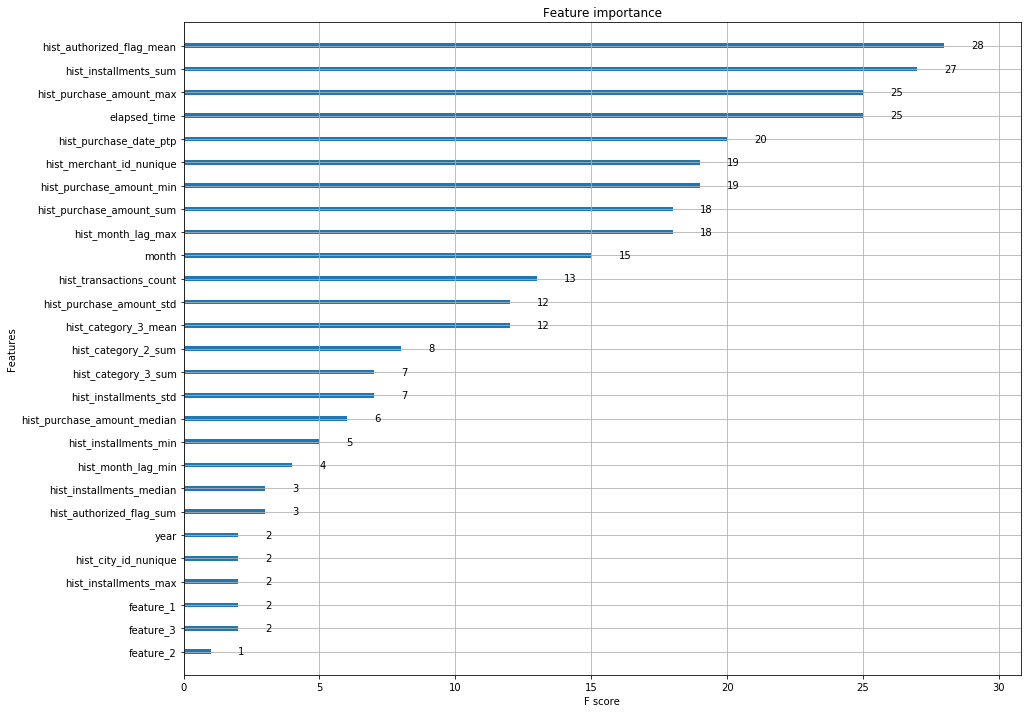

In [68]:
plt.rcParams['figure.figsize'] = [15, 12]
xgb.plot_importance(xg_reg)
plt.show()

In [51]:
data_dmatrix = xgb.DMatrix(data=X_train2,label=y_train)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

#Shortened features to top 15 with highest trend correlation
#Then eliminated features with high variation inflation factor, aka high multicolinearity

[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

In [39]:
cv_results.tail(1)

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         3.795172         0.03574        3.814709       0.068028

In [52]:
data_dmatrix_raw = xgb.DMatrix(data=train.drop(['target', 'first_active_month', 'card_id'], axis=1),label=train.target)

cv_results_raw = xgb.cv(dtrain=data_dmatrix_raw, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

#RSME score with minimal feature engineering
#Only using features 1 2 3, month, year, and elapsed time

[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[

[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=

In [53]:
cv_results_raw.tail(1)

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         3.841647        0.009548        3.842758       0.018543

Cv_results_raw is the data uncleaned and untouched. I goal here is to test the impact of my feature engineering on the rmse score. Looking at the test_rmse_mean, I can see that it improved the score by a mere .3. 

In [42]:
X_train.columns

Index(['feature_3', 'year', 'feature_2', 'hist_month_lag_max',
       'hist_authorized_flag_mean', 'hist_month_lag_min',
       'hist_category_2_mean', 'hist_category_3_sum',
       'hist_merchant_id_nunique', 'hist_installments_sum',
       'hist_purchase_date_ptp', 'hist_purchase_amount_sum',
       'hist_installments_min', 'hist_transactions_count',
       'hist_purchase_amount_std'],
      dtype='object')

In [54]:
data_dmatrix_15 = xgb.DMatrix(data=X_train,label=y_train) 

cv_results_15 = xgb.cv(dtrain=data_dmatrix_15, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results_15.tail(1)

#top 15 features with highest trend correlation

[22:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         3.746389        0.032451        3.784073       0.063585

In [76]:
data_dmatrix_all = xgb.DMatrix(data=new_train.drop(['first_active_month', 'card_id', 'target'], axis=1),label=y_train) 

cv_results_all = xgb.cv(dtrain=data_dmatrix_all, params=params, nfold=3,
                    num_boost_round=70,early_stopping_rounds=15,metrics="rmse", as_pandas=True, seed=123)

cv_results_all.tail(1)

#All features created by the groupby function

[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[23:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
69           3.6872        0.029567        3.754296       0.062019

**Including all the features created by the groupby function, aggregrate_historical_transactions, did improve the rmse score on the test set, but not as greatly as limiting only to the top 15 features that held the greatest trend correlation among the training and validation set, obtained through featexp's get_trend_stats module.**

In [73]:
cv_results_top21.tail(1)

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         3.736845        0.030297         3.78154       0.064287

In [77]:
new_train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'year', 'month', 'elapsed_time', 'hist_transactions_count',
       'hist_authorized_flag_sum', 'hist_authorized_flag_mean',
       'hist_merchant_id_nunique', 'hist_city_id_nunique',
       'hist_purchase_amount_sum', 'hist_purchase_amount_median',
       'hist_purchase_amount_max', 'hist_purchase_amount_min',
       'hist_purchase_amount_std', 'hist_installments_sum',
       'hist_installments_median', 'hist_installments_max',
       'hist_installments_min', 'hist_installments_std',
       'hist_purchase_date_ptp', 'hist_month_lag_min', 'hist_month_lag_max',
       'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_sum',
       'hist_category_2_mean', 'hist_category_3_sum', 'hist_category_3_mean'],
      dtype='object')

In [81]:
train_no_outlier = new_train[(new_train.target > -15)]

(195477, 33)

In [85]:
data_dmatrix_no_out = xgb.DMatrix(data=train_no_outlier.drop(['first_active_month', 'card_id', 'target'], axis=1),label=y_train) 

cv_results_no_out = xgb.cv(dtrain=data_dmatrix_all, params=params, nfold=3,
                    num_boost_round=70,early_stopping_rounds=15,metrics="rmse", as_pandas=True, seed=123)

cv_results_no_out.tail(1)

[23:11:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:11:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:11:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[23:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:11:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:11:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
69           3.6872        0.029567        3.754296       0.062019